<a href="https://colab.research.google.com/github/Eieiz007/Deep-learning/blob/main/Autoformer_model_stock_nvidia_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is my mini project.  
Nvidia Stock time series forcasting by Transformer model   

# PIP

In [6]:
# !pip install yfinance

In [7]:
# !pip install pytorch-lightning==1.9.5

In [8]:
# !pip install pytorch-forecasting

# Import

In [49]:
import pytorch_lightning as pl
print(pl.__version__)  # version < 2

1.9.5


In [50]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import numpy as np
from sklearn.model_selection import train_test_split


import torch
from torch.utils.data import TensorDataset, DataLoader
from pytorch_forecasting.models import TemporalFusionTransformer
from torch.optim import Adam
from pytorch_forecasting import TimeSeriesDataSet
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning import Trainer
from pytorch_forecasting.metrics import MAPE, MAE, RMSE

# API datasets

In [88]:
stocks = ["NVDA"]
df = {ticker: yf.download(ticker, period="5y")["Close"] for ticker in stocks} # pervious 5 year

[*********************100%***********************]  1 of 1 completed


In [89]:
df = pd.concat([df['NVDA']], axis=1)
df.columns = ["NVDA"]
df

,NVDA
Date,
2020-03-02,6.886016
2020-03-03,6.623459
2020-03-04,7.087293
2020-03-05,6.807796
2020-03-06,6.627195
...,...
2025-02-24,130.279999
2025-02-25,126.629997
2025-02-26,131.279999


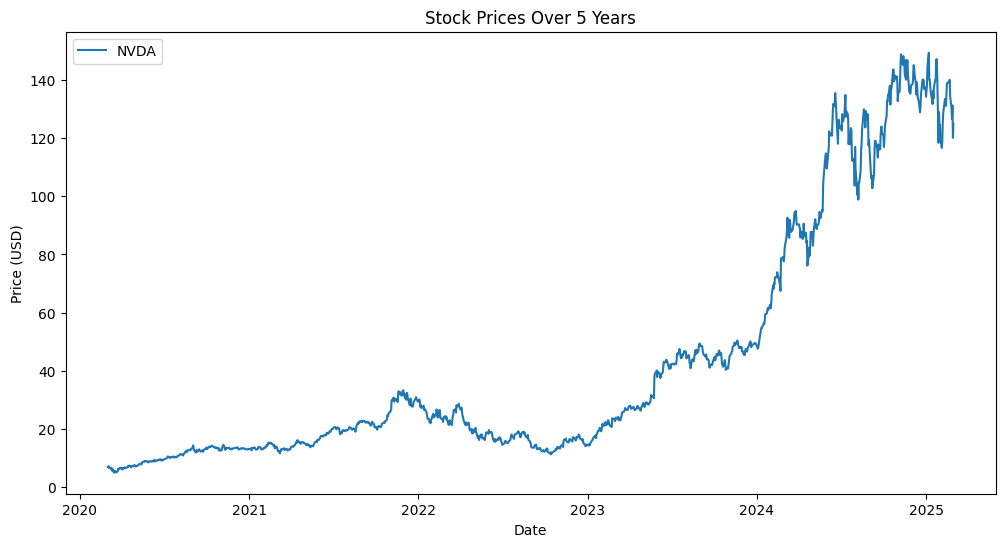

In [90]:
plt.figure(figsize=(12, 6))
for stock in df.columns:
    plt.plot(df[stock], label=stock)
plt.legend()
plt.title("Stock Prices Over 5 Years")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.show()

# Data cleaning

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1257 entries, 2020-03-02 to 2025-02-28
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   NVDA    1257 non-null   float64
dtypes: float64(1)
memory usage: 19.6 KB


In [15]:
df.describe()

,NVDA
count,1257.000000
mean,42.402577
std,41.170577
min,4.892426
25%,14.142092
50%,22.345097
75%,48.122128
max,149.429993


# 1.Missing Values

In [16]:
missing_values = df.isnull().sum()
print("Missing values:\n", missing_values)

Missing values:
 NVDA    0
dtype: int64


# 2.Check Datetime Index

In [17]:
df = df.sort_index()
df.head()

,NVDA
Date,
2020-03-02,6.886015
2020-03-03,6.623459
2020-03-04,7.087292
2020-03-05,6.807796
2020-03-06,6.627195


# Seasonality decompostion

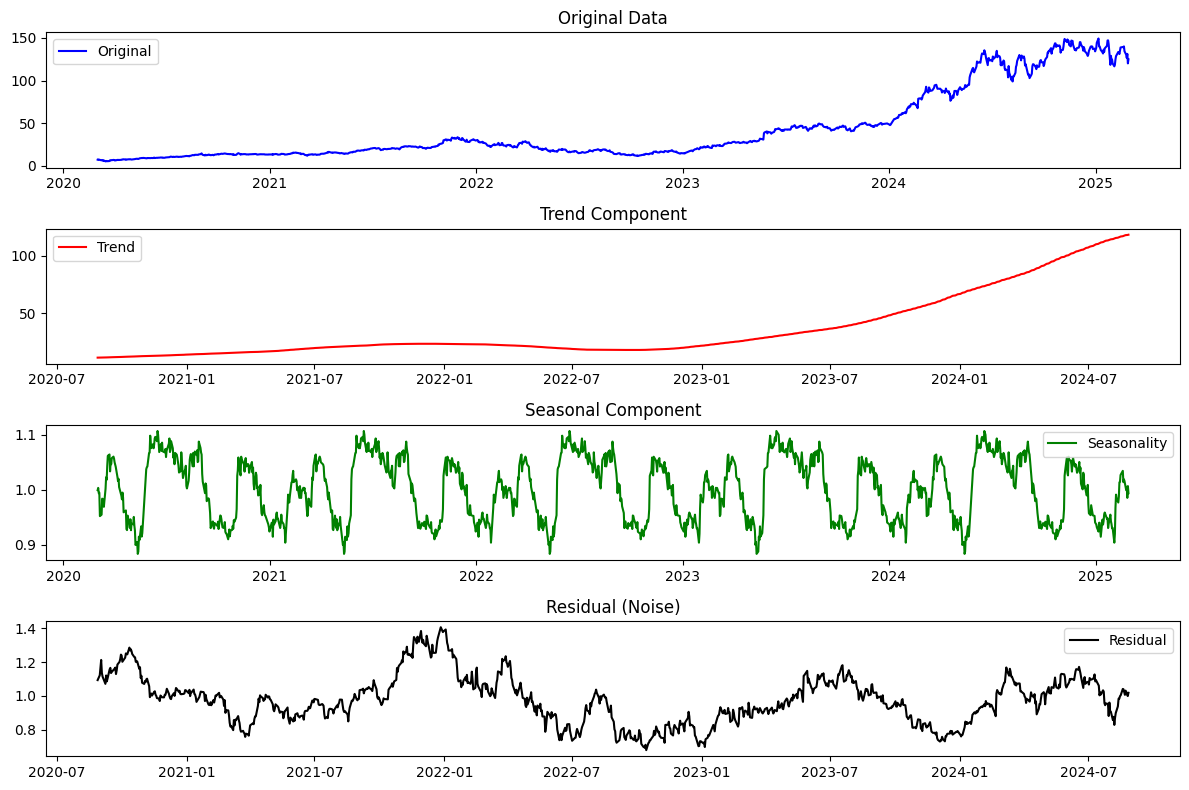

In [18]:
stock = "NVDA"
decomposition = sm.tsa.seasonal_decompose(df[stock], model="multiplicative", period=252)  # 252 วัน = 1 ปีในตลาดหุ้น

plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(df[stock], label="Original", color="blue")
plt.title("Original Data")
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(decomposition.trend, label="Trend", color="red")
plt.title("Trend Component")
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(decomposition.seasonal, label="Seasonality", color="green")
plt.title("Seasonal Component")
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(decomposition.resid, label="Residual", color="black")
plt.title("Residual (Noise)")
plt.legend()

plt.tight_layout()
plt.show()

# ADF Statistic Test

In [19]:
def check_stationarity(series):
    print(series.reset_index().columns[1])
    result = adfuller(series.dropna())
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    if result[1] < 0.05:
        print("data not is Stationary (p < 0.05)")
        print(" ")
    else:
        print("data is Stationary (p >= 0.05)")
        print(" ")

check_stationarity(df["NVDA"])

NVDA
ADF Statistic: 0.3594658184704871
p-value: 0.9799141587862576
data is Stationary (p >= 0.05)
 


# Data prepartation for train model

In [91]:
df['Month'] = df.index.month
df['Year'] = df.index.year
df.head()

,NVDA,Month,Year
Date,,,
2020-03-02,6.886016,3,2020
2020-03-03,6.623459,3,2020
2020-03-04,7.087293,3,2020
2020-03-05,6.807796,3,2020
2020-03-06,6.627195,3,2020


In [95]:
df['Month'] = df['Month'].astype(int)
df['Year'] = df['Year'].astype(int)
df = pd.get_dummies(df, columns=['Month', 'Year'], drop_first=False)

In [98]:
for column in df.columns:
    if df[column].dtype == 'bool':  # ตรวจสอบว่าเป็น bool หรือไม่
        df[column] = df[column].astype(int)

In [100]:
df.head()

,NVDA,Month_1,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,Year_2020,Year_2021,Year_2022,Year_2023,Year_2024,Year_2025
Date,,,,,,,,,,,,,,,,,,,
2020-03-02,6.886016,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2020-03-03,6.623459,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2020-03-04,7.087293,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2020-03-05,6.807796,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2020-03-06,6.627195,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


# MinMaxScaler